In [73]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests
%matplotlib inline 


In [131]:
df = pd.read_csv("./ab_browser_test.csv")
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [208]:
# means = df.groupby('slot').n_clicks.mean()
# 100 * (means - min(means))[1] / min(means)
slot_clicks = df.groupby('slot').agg('sum')['n_clicks']
100 * (slot_clicks[1] - slot_clicks[0]) / slot_clicks[0]

1.6135689824415806

In [55]:
def get_bootstrap_samples(data, n_samples):
    """ 
    data: numpy vector 
    n_samples: scalar 
    """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def iter_bootstrap_samples(data, n_samples):
    i = 0
    while i < n_samples:
        indices = np.random.randint(0, len(data), len(data))
        sample = data[indices]
        yield sample
        i += 1

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


In [132]:
exp_clicks = df.loc[df.slot == 'exp', 'n_clicks']
control_clicks = df.loc[df.slot == 'control', 'n_clicks']

In [133]:
bootstrap_exp_mean = get_bootstrap_samples(exp_clicks.values, 1000).mean(1)
bootstrap_exp_median = np.median(get_bootstrap_samples(exp_clicks.values, 1000), axis=1)
bootstrap_con_mean = get_bootstrap_samples(control_clicks.values, 1000).mean(1)
bootstrap_con_median = np.median(get_bootstrap_samples(control_clicks.values, 1000), axis=1)

In [134]:
mean_diff = bootstrap_exp_mean - bootstrap_con_mean
median_diff = bootstrap_exp_median - bootstrap_con_median
stat_intervals(mean_diff, 0.05), stat_intervals(median_diff, 0.05)

(array([ 0.20049515,  0.41205358]), array([ 1.,  1.]))

In [135]:
np.random.seed(0)
n_boot_samples = 500
boot_samples = get_bootstrap_samples(control_clicks.values, n_boot_samples)
boot_con_means = boot_samples.mean(1)

In [136]:
def get_chi2(sample):
    return np.sum(np.power(sample - sample.mean(), 2))
boot_con_chi2 = list(map(get_chi2, boot_samples))

((array([ -2.99209858e+00,  -2.71015927e+00,  -2.55162541e+00,
          -2.43921385e+00,  -2.35113311e+00,  -2.27822091e+00,
          -2.21572267e+00,  -2.16084152e+00,  -2.11178767e+00,
          -2.06734403e+00,  -2.02664403e+00,  -1.98904794e+00,
          -1.95406954e+00,  -1.92133033e+00,  -1.89052965e+00,
          -1.86142459e+00,  -1.83381593e+00,  -1.80753820e+00,
          -1.78245240e+00,  -1.75844061e+00,  -1.73540186e+00,
          -1.71324904e+00,  -1.69190643e+00,  -1.67130780e+00,
          -1.65139483e+00,  -1.63211595e+00,  -1.61342528e+00,
          -1.59528183e+00,  -1.57764883e+00,  -1.56049314e+00,
          -1.54378481e+00,  -1.52749667e+00,  -1.51160399e+00,
          -1.49608418e+00,  -1.48091659e+00,  -1.46608224e+00,
          -1.45156367e+00,  -1.43734479e+00,  -1.42341071e+00,
          -1.40974764e+00,  -1.39634279e+00,  -1.38318426e+00,
          -1.37026095e+00,  -1.35756253e+00,  -1.34507932e+00,
          -1.33280226e+00,  -1.32072287e+00,  -1.308833

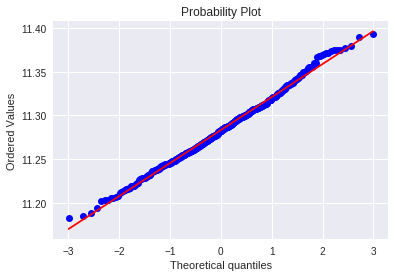

In [137]:
scipy.stats.probplot(boot_con_means, dist="norm", plot=plt)

((array([ 409.75447609,  417.6076492 ,  422.06789456,  425.24996033,
          427.75458277,  429.83540071,  431.6244473 ,  433.19958802,
          434.61075771,  435.89197548,  437.06750372,  438.15527962,
          439.16895419,  440.11916758,  441.0143809 ,  441.86143812,
          442.66595697,  443.43260794,  444.16531782,  444.86742108,
          445.54177438,  446.19084464,  446.81677748,  447.42145127,
          448.00652022,  448.57344901,  449.12354099,  449.6579613 ,
          450.17775596,  450.68386771,  451.17714938,  451.65837504,
          452.12824958,  452.58741674,  453.03646615,  453.47593922,
          453.90633437,  454.32811152,  454.74169597,  455.14748186,
          455.54583518,  455.93709642,  456.3215829 ,  456.69959087,
          457.07139736,  457.43726183,  457.79742761,  458.1521233 ,
          458.50156388,  458.84595184,  459.1854781 ,  459.52032292,
          459.85065667,  460.17664058,  460.49842735,  460.81616179,
          461.12998133,  461.44001

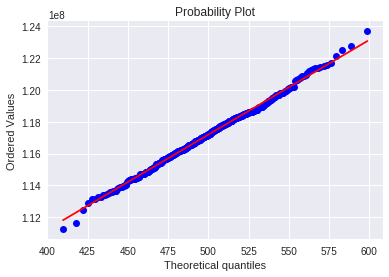

In [138]:
scipy.stats.probplot(boot_con_chi2, dist="chi2", 
                     sparams=(n_boot_samples-1), plot=plt)

In [139]:
user_exp = df.loc[df.slot=='exp', :].groupby('userID').agg('sum')['n_clicks']
user_con = df.loc[df.slot=='control', :].groupby('userID').agg('sum')['n_clicks']

In [140]:
mannwhitneyu(user_exp, user_con), \
scipy.stats.mannwhitneyu(user_exp, user_con, alternative='two-sided')

(MannwhitneyuResult(statistic=41140868471.0, pvalue=8.6942943775208786e-75),
 MannwhitneyuResult(statistic=41140868471.0, pvalue=8.6942943775208786e-75))

In [129]:
user_exp.shape, user_con.shape

((281450,), (284392,))

In [181]:
browser_exp = df.loc[df.slot=='exp', :].groupby(['browser', 'userID']).agg('sum')['n_clicks']
browser_con = df.loc[df.slot=='control', :].groupby(['browser', 'userID']).agg('sum')['n_clicks']
browsers = browser_exp.index.levels[0]

pval = []
for browser in browsers:
    pval.append(scipy.stats.mannwhitneyu(browser_exp.loc[browser, :], 
                                         browser_con.loc[browser, :])[1])
pval

[0.0,
 0.037400601430108017,
 0.027243860419724101,
 0.45366656388735377,
 0.25740551522100319,
 0.40760617658454984]

In [185]:
reject, p_corrected, a1, a2 = multipletests(pval, 
                                            alpha = 0.05, 
                                            method = 'holm')
p_corrected, reject

(array([ 0.        ,  0.14960241,  0.1362193 ,  0.81521235,  0.77221655,
         0.81521235]),
 array([ True, False, False, False, False, False], dtype=bool))

In [205]:
aggr = df.groupby(['slot', 'browser']).agg('sum')
aggr.iloc[:, 3] / aggr.iloc[:, 1] 

slot     browser    
control  Browser #14    0.778134
         Browser #17    0.284319
         Browser #2     0.459851
         Browser #20    0.347716
         Browser #22    0.358566
         Browser #4     0.468110
exp      Browser #14    0.419805
         Browser #17    0.291470
         Browser #2     0.440118
         Browser #20    0.327034
         Browser #22    0.344927
         Browser #4     0.431077
dtype: float64